In [79]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
import numpy as np
from scipy.optimize import least_squares
from aa_helpers import create_plot_with_background
import pandas as pd
import glob
import seaborn as sns


In [80]:
df = pd.read_feather("combined_all_lambda_data.feather")
df

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_py,gamtwo_pz,gamtwo_vx,gamtwo_vy,gamtwo_vz,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4,3122,1,134217728,-0.139277,0.062614,31.113912,-0.067507,0.000640,...,0.082274,3.843211,-4.236915,1.875058,940.263365,-182.985431,130.331637,6940.804748,3.073184,0.0
2,2,4,3122,1,134217728,-1.666138,0.211775,30.953969,-0.027048,0.006753,...,-0.035283,2.576297,-16.709645,2.127195,331.802817,-236.338462,-40.261238,3426.886648,0.948990,0.0
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,3122,1,134217728,-0.728119,-0.635623,31.608930,-0.042067,0.001390,...,-0.015382,1.622836,-39.878694,-34.774637,1675.921870,-96.233964,-84.811255,6954.767017,5.966232,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563785,499996,4,3122,1,134217728,-0.884341,-0.615085,37.018614,-0.011745,-0.024622,...,0.054056,4.083450,-3.373053,-2.362499,184.886373,-227.016039,87.304909,6958.468336,0.329498,0.0
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563787,499998,4,3122,1,134217728,-0.165018,-0.626539,24.329761,-0.050402,0.038077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
p_pi_minus_decays = df[
    df['prot_id'].notna() & 
    df['pimin_id'].notna() &
    df['neut_id'].isna() &    
    df['pizero_id'].isna()    
].copy()


In [82]:
m_proton = 0.93827  
m_pion = 0.13957    


p_pi_minus_decays['prot_E'] = np.sqrt(
    p_pi_minus_decays['prot_px']**2 + 
    p_pi_minus_decays['prot_py']**2 + 
    p_pi_minus_decays['prot_pz']**2 + 
    m_proton**2
)

p_pi_minus_decays['pimin_E'] = np.sqrt(
    p_pi_minus_decays['pimin_px']**2 + 
    p_pi_minus_decays['pimin_py']**2 + 
    p_pi_minus_decays['pimin_pz']**2 + 
    m_pion**2
)


p_pi_minus_decays['lambda_E'] = p_pi_minus_decays['prot_E'] + p_pi_minus_decays['pimin_E']


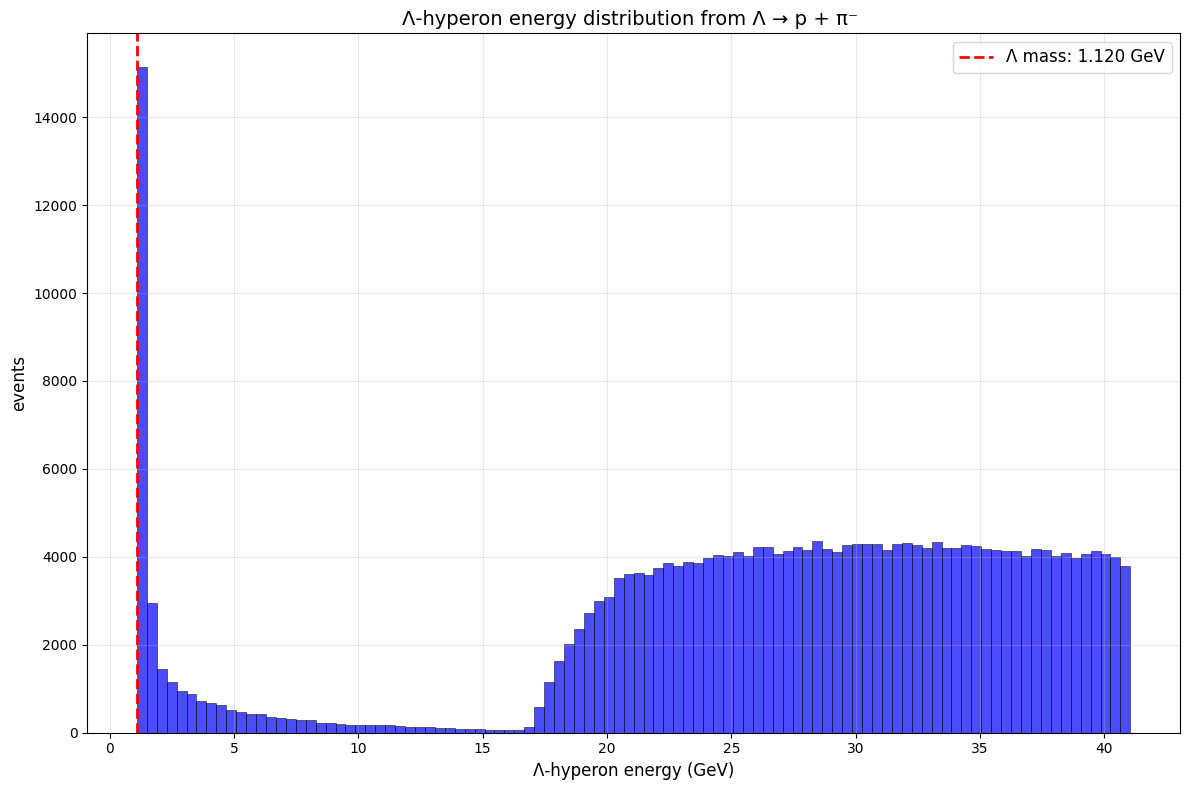

In [83]:
plt.figure(figsize=(12, 8))

plt.hist(p_pi_minus_decays['lambda_E'], bins=100, alpha=0.7, color='blue', 
         edgecolor='black', linewidth=0.5)

plt.axvline(1.120, color='red', linestyle='--', linewidth=2, 
           label='Λ mass: 1.120 GeV')

plt.xlabel('Λ-hyperon energy (GeV)', fontsize=12)
plt.ylabel('events', fontsize=12)
plt.title('Λ-hyperon energy distribution from Λ → p + π⁻ ', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

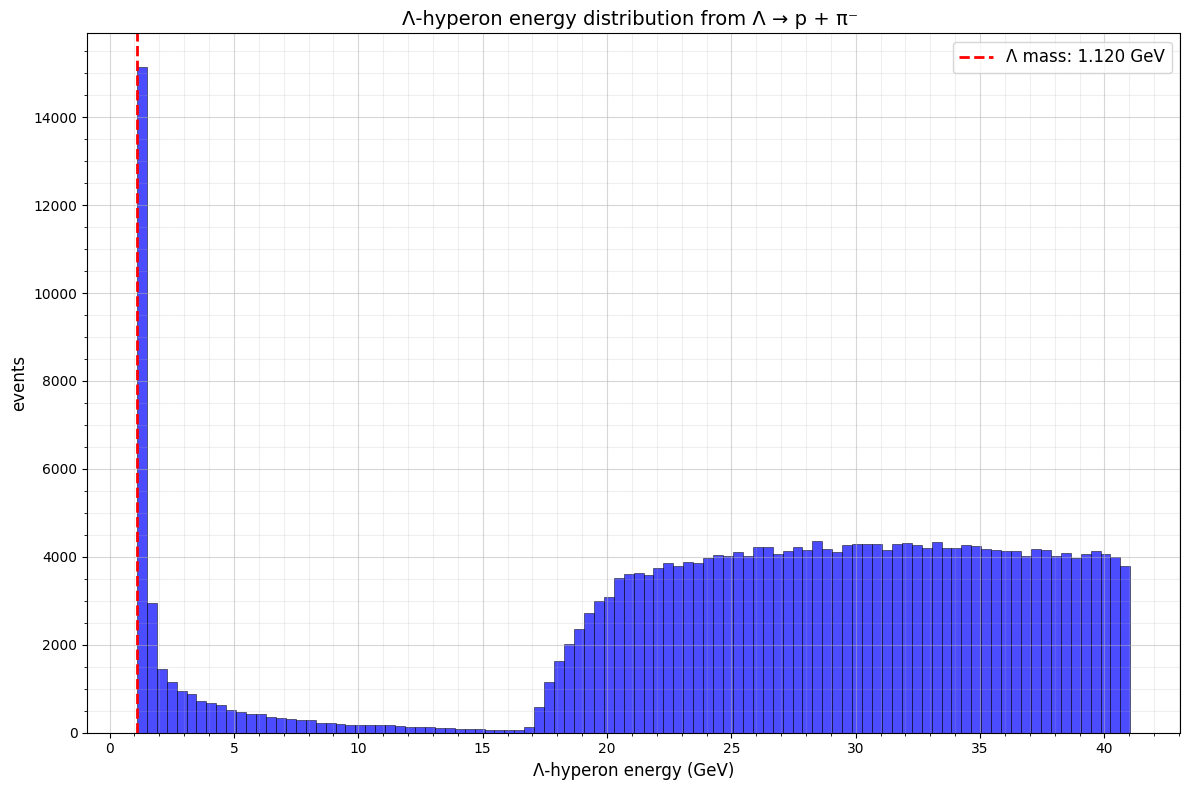

In [84]:
plt.figure(figsize=(12, 8))

plt.hist(p_pi_minus_decays['lambda_E'], bins=100, alpha=0.7, color='blue', 
         edgecolor='black', linewidth=0.5)

plt.axvline(1.120, color='red', linestyle='--', linewidth=2, 
           label='Λ mass: 1.120 GeV')

plt.xlabel('Λ-hyperon energy (GeV)', fontsize=12)
plt.ylabel('events', fontsize=12)
plt.title('Λ-hyperon energy distribution from Λ → p + π⁻ ', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.minorticks_on()  
plt.grid(True, which='major', alpha=0.5) 
plt.grid(True, which='minor', alpha=0.2) 


plt.tight_layout()
plt.show()

In [85]:

def calculate_invariant_mass(row):
    E_total = row['prot_E'] + row['pimin_E']
    px_total = row['prot_px'] + row['pimin_px']
    py_total = row['prot_py'] + row['pimin_py']
    pz_total = row['prot_pz'] + row['pimin_pz']
    p_total_sq = px_total**2 + py_total**2 + pz_total**2
    return np.sqrt(E_total**2 - p_total_sq)

p_pi_minus_decays['invariant_mass'] = p_pi_minus_decays.apply(calculate_invariant_mass, axis=1)


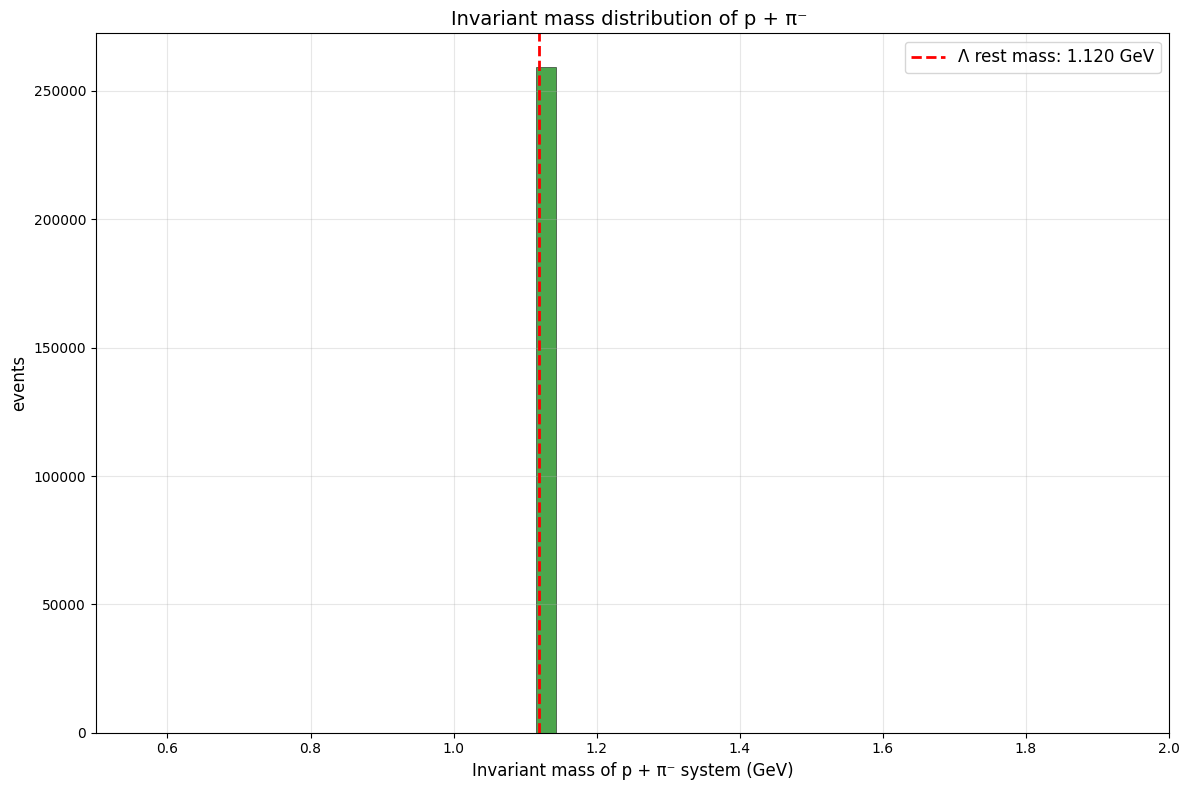

In [86]:
plt.figure(figsize=(12, 8))

plt.hist(p_pi_minus_decays['invariant_mass'], 
         bins=100, 
         alpha=0.7, 
         color='green', 
         edgecolor='black', 
         linewidth=0.5)

plt.axvline(1.120, color='red', linestyle='--', linewidth=2, 
           label='Λ rest mass: 1.120 GeV')

plt.xlabel('Invariant mass of p + π⁻ system (GeV)', fontsize=12)
plt.ylabel('events', fontsize=12)
plt.title('Invariant mass distribution of p + π⁻ ', fontsize=14)
plt.legend(fontsize=12)

plt.grid(True, alpha=0.3)
plt.xlim(0.5, 2.0)
plt.tight_layout()
plt.show()

In [87]:
df_p_pi_minis = p_pi_minus_decays.copy()
df_p_pi_minis

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_vz,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd,prot_E,pimin_E,lambda_E,invariant_mass
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,NaN,18.343530,4.580105,22.923635,1.115598
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,NaN,19.402469,1.606190,21.008659,1.115598
7,7,4,3122,1,134217728,-0.874955,-0.206428,27.917657,0.178236,-0.011964,...,NaN,NaN,NaN,NaN,NaN,NaN,23.724715,4.229682,27.954396,1.115598
13,11,4,3122,1,134217728,-0.928876,-0.275190,18.865436,0.004515,-0.001070,...,NaN,NaN,NaN,NaN,NaN,NaN,15.572135,3.351072,18.923207,1.115598
17,15,4,3122,1,134217728,0.057593,0.311856,35.954789,-0.272678,0.003106,...,NaN,NaN,NaN,NaN,NaN,NaN,31.024198,4.949292,35.973490,1.115598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563781,499993,4,3122,1,134217728,-0.673949,1.010529,39.499559,0.119686,0.010100,...,NaN,NaN,NaN,NaN,NaN,NaN,34.122173,5.411801,39.533974,1.115598
563783,499994,134,3122,0,1207959552,0.030177,-0.450537,3.775613,-132.761314,10.319317,...,NaN,NaN,NaN,NaN,NaN,NaN,3.259683,0.703131,3.962813,1.115681
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,NaN,21.689563,5.087566,26.777129,1.115598
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,NaN,22.276459,3.584627,25.861086,1.115598


In [88]:
df_p_pi_minis['is_lam_primary'] = np.where(df_p_pi_minis['lambda_E'] > 19, True, 
                                          np.where(df_p_pi_minis['lambda_E'] < 19, False, np.nan))
df_p_pi_minis

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd,prot_E,pimin_E,lambda_E,invariant_mass,is_lam_primary
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,18.343530,4.580105,22.923635,1.115598,1.0
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,19.402469,1.606190,21.008659,1.115598,1.0
7,7,4,3122,1,134217728,-0.874955,-0.206428,27.917657,0.178236,-0.011964,...,NaN,NaN,NaN,NaN,NaN,23.724715,4.229682,27.954396,1.115598,1.0
13,11,4,3122,1,134217728,-0.928876,-0.275190,18.865436,0.004515,-0.001070,...,NaN,NaN,NaN,NaN,NaN,15.572135,3.351072,18.923207,1.115598,0.0
17,15,4,3122,1,134217728,0.057593,0.311856,35.954789,-0.272678,0.003106,...,NaN,NaN,NaN,NaN,NaN,31.024198,4.949292,35.973490,1.115598,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563781,499993,4,3122,1,134217728,-0.673949,1.010529,39.499559,0.119686,0.010100,...,NaN,NaN,NaN,NaN,NaN,34.122173,5.411801,39.533974,1.115598,1.0
563783,499994,134,3122,0,1207959552,0.030177,-0.450537,3.775613,-132.761314,10.319317,...,NaN,NaN,NaN,NaN,NaN,3.259683,0.703131,3.962813,1.115681,0.0
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,21.689563,5.087566,26.777129,1.115598,1.0
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,22.276459,3.584627,25.861086,1.115598,1.0


C:\Users\User\AppData\Local\Temp\ipykernel_13836\2758382926.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


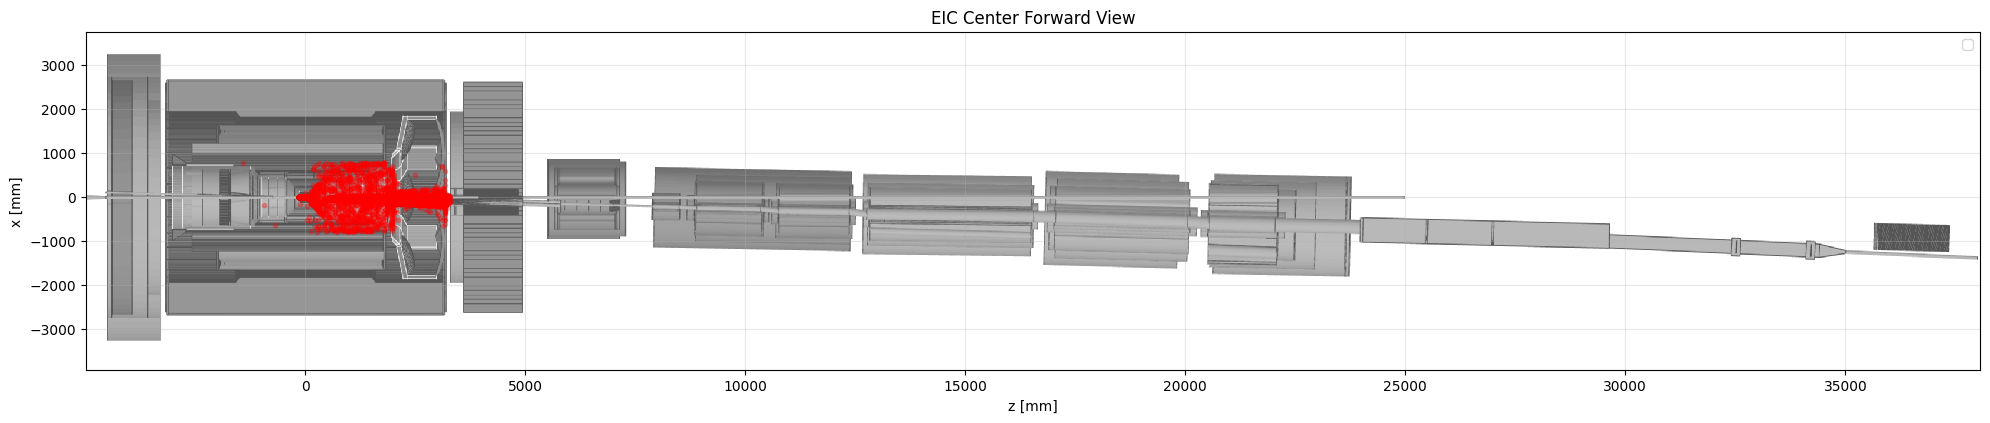

In [89]:
df_p_pi_minis

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df_p_pi_minis['lam_vz']
y_axis = df_p_pi_minis['lam_vx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, )

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_13836\3421016092.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


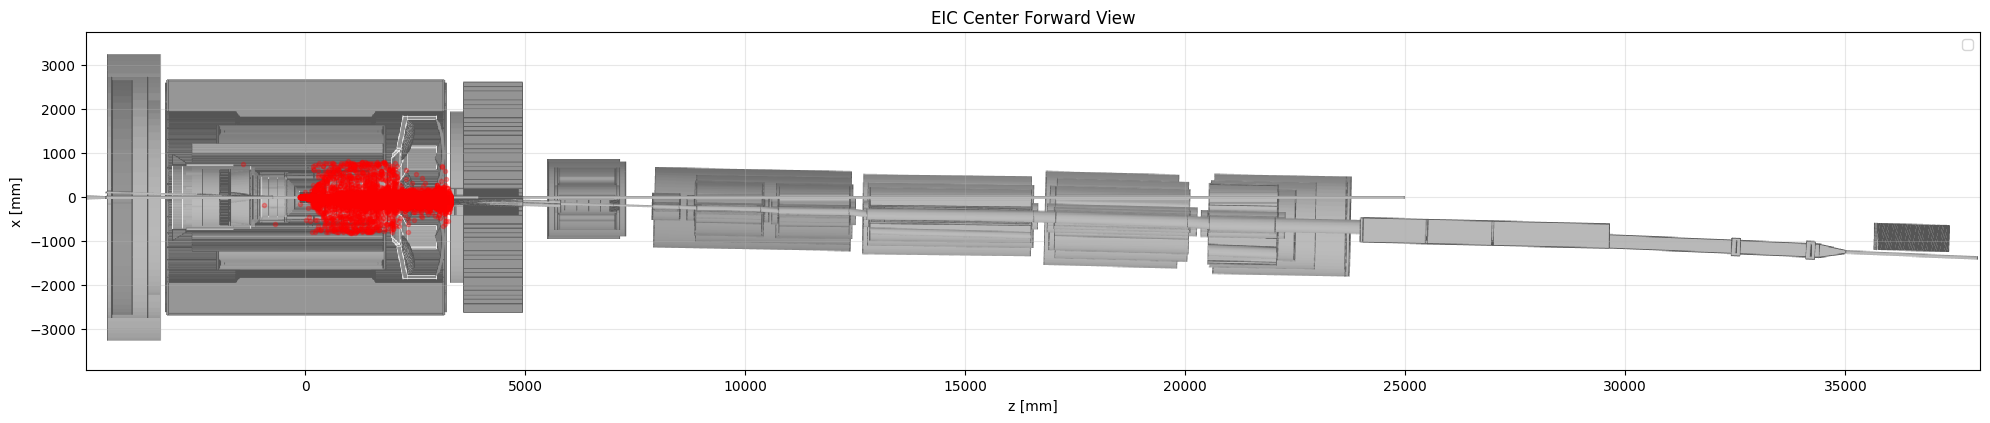

In [90]:
df_p_pi_minis

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = df_p_pi_minis['lam_epz']
y_axis = df_p_pi_minis['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, )

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_13836\1737240973.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


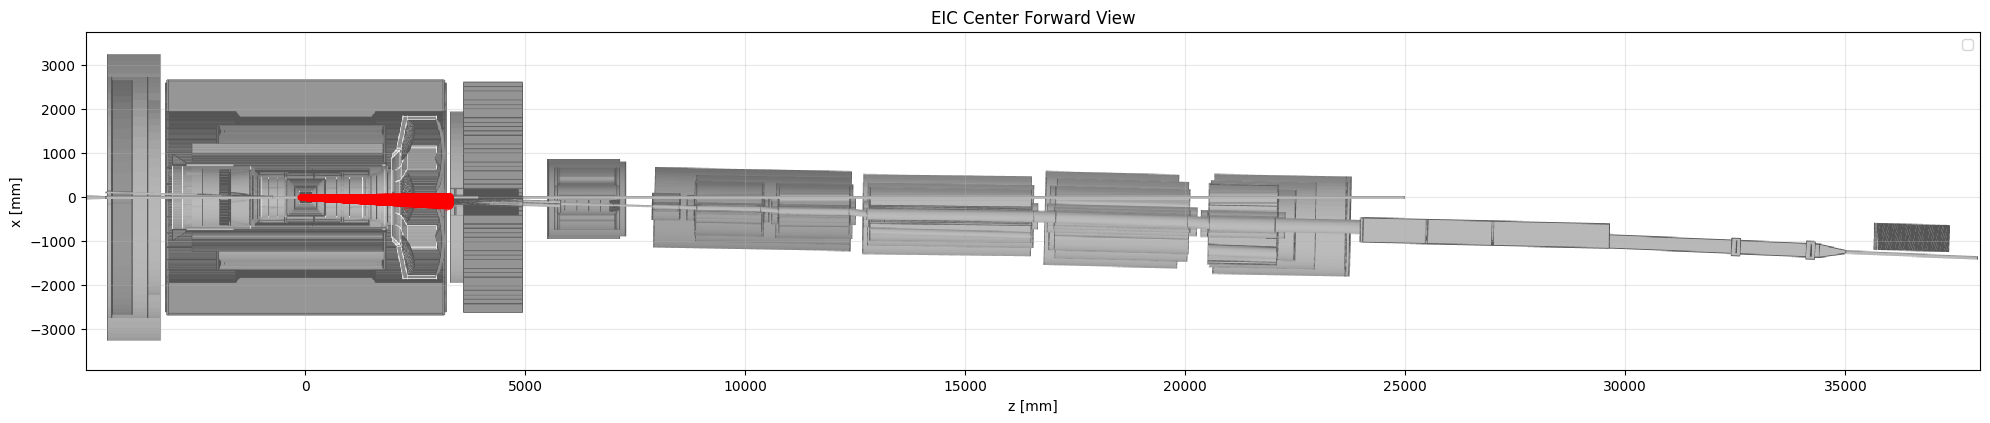

In [91]:
high_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == True]

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = high_energy_lambdas['lam_epz']
y_axis = high_energy_lambdas['lam_epx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, )

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_13836\2890447743.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


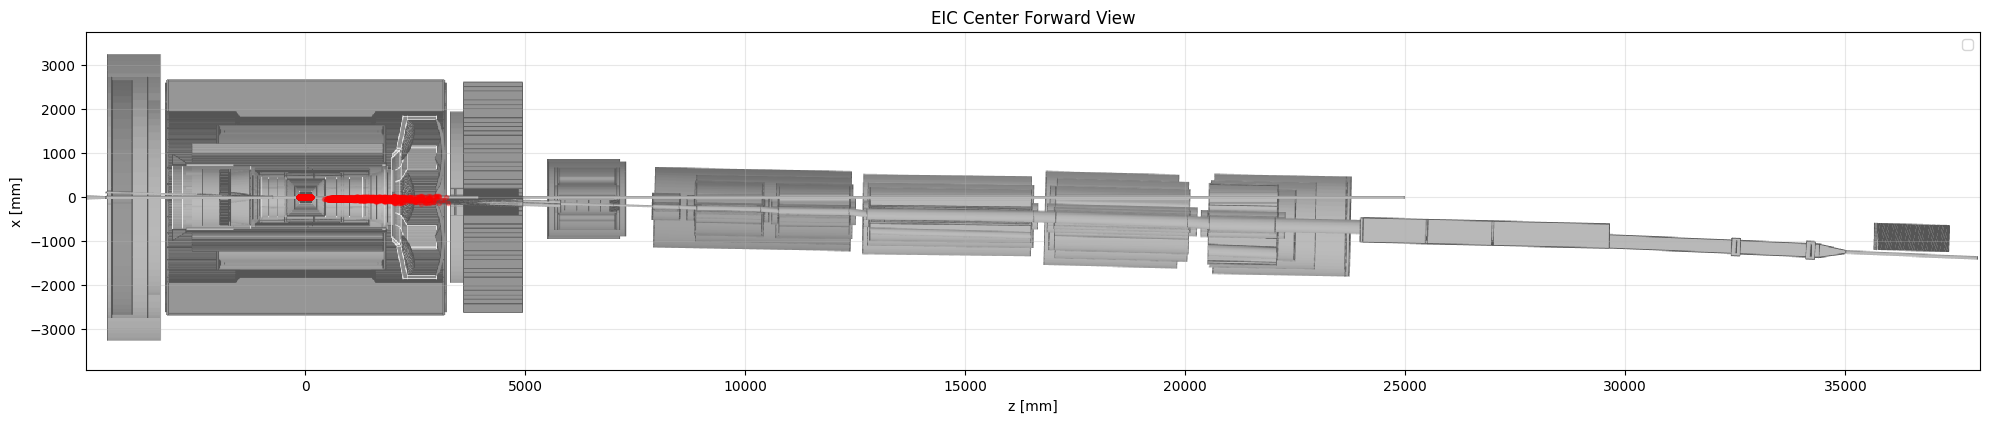

In [114]:
high_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == True]

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = high_energy_lambdas['lam_vz']
y_axis = high_energy_lambdas['lam_vx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, )

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [115]:
high_energy_lambdas = df_p_pi_minis[(df_p_pi_minis['is_lam_primary'] == True) & (df_p_pi_minis['lam_vz'] < 300)]

high_energy_lambdas['lambda_E']

0         22.923635
3         21.008659
7         27.954396
17        35.973490
18        21.918459
            ...    
563779    20.574592
563781    39.533974
563784    26.777129
563786    25.861086
563787    24.363941
Name: lambda_E, Length: 219481, dtype: float64

(array([17310., 20508., 21882., 22689., 23109., 23340., 23278., 22899.,
        22440., 22026.]),
 array([19.00038009, 21.20420954, 23.40803898, 25.61186843, 27.81569788,
        30.01952732, 32.22335677, 34.42718622, 36.63101566, 38.83484511,
        41.03867456]),
 <BarContainer object of 10 artists>)

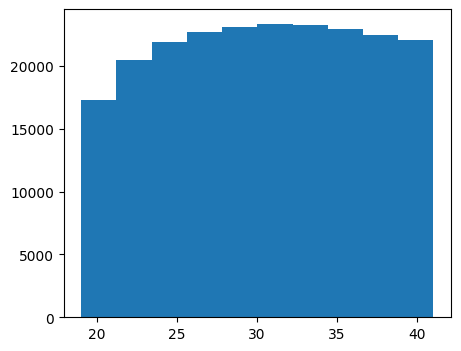

In [116]:
plt.figure(figsize=(5, 4))
plt.hist(high_energy_lambdas['lambda_E'])

C:\Users\User\AppData\Local\Temp\ipykernel_13836\1299802353.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


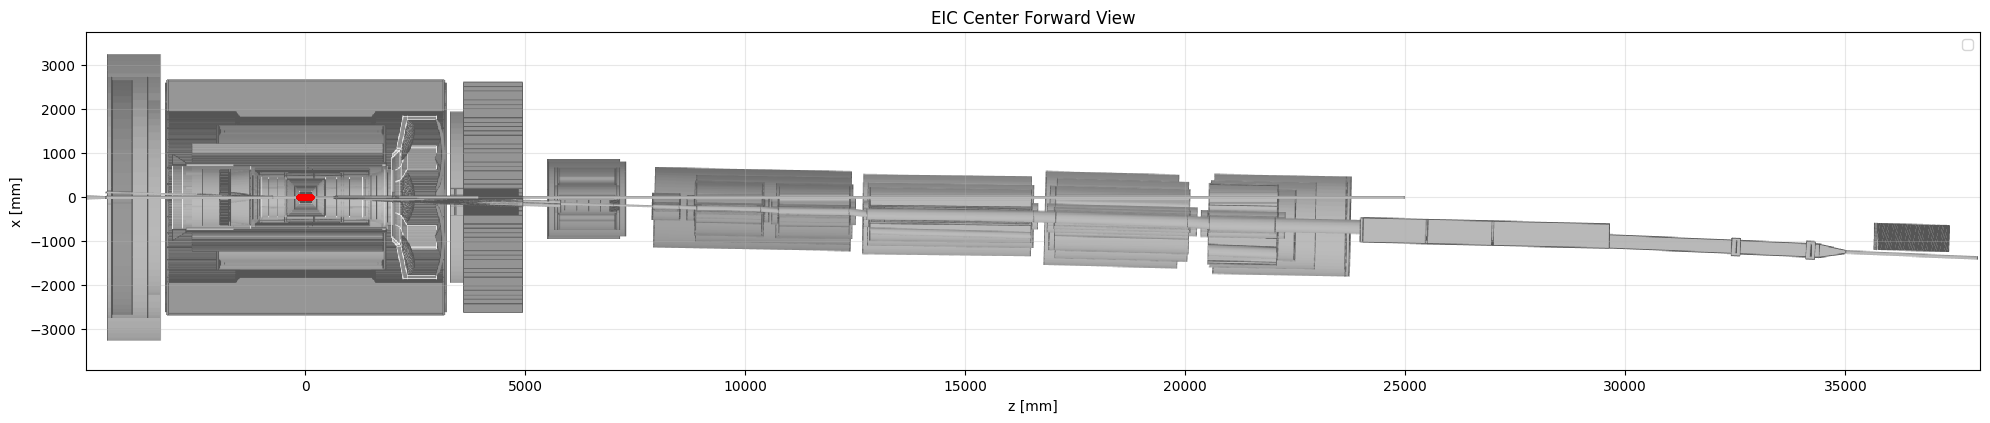

In [113]:
fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = high_energy_lambdas['lam_vz']
y_axis = high_energy_lambdas['lam_vx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, )

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [117]:
test = df_p_pi_minis[(df_p_pi_minis['is_lam_primary'] == True) & (df_p_pi_minis['lam_vz'] > 300)]

C:\Users\User\AppData\Local\Temp\ipykernel_13836\3797615694.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


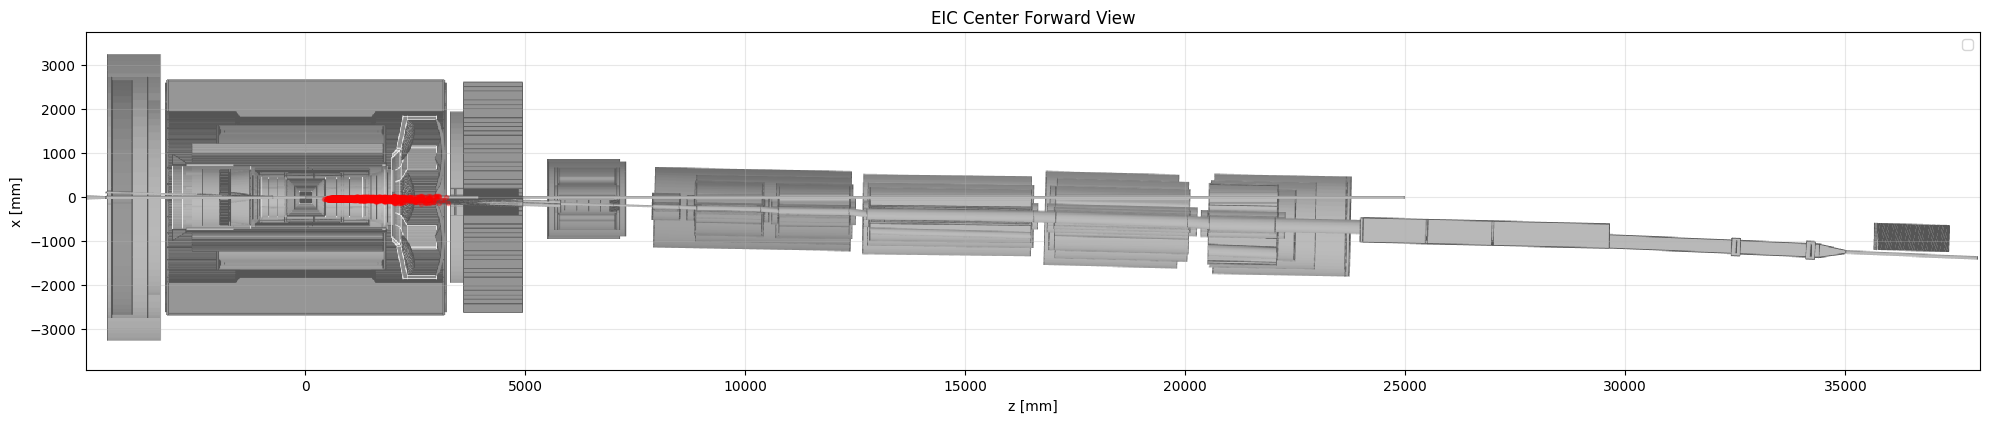

In [118]:
fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")

x_axis = test['lam_vz']
y_axis = test['lam_vx']

ax.plot(x_axis, y_axis, marker="o", linestyle="none", alpha=0.3, 
        color='red', markersize=3, )

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

(array([288., 231., 226., 211., 210., 197., 163., 160., 117.,  78.]),
 array([19.00336607, 21.18664161, 23.36991714, 25.55319267, 27.7364682 ,
        29.91974373, 32.10301926, 34.28629479, 36.46957032, 38.65284585,
        40.83612138]),
 <BarContainer object of 10 artists>)

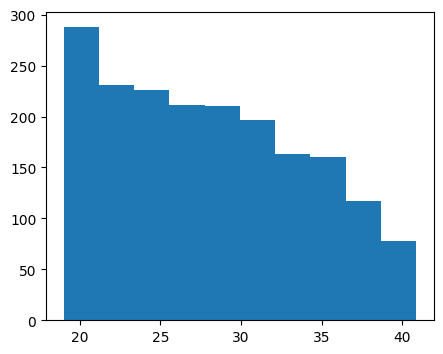

In [122]:
plt.figure(figsize=(5, 4))
plt.hist(test['lambda_E'])

C:\Users\User\AppData\Local\Temp\ipykernel_13836\3935078926.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


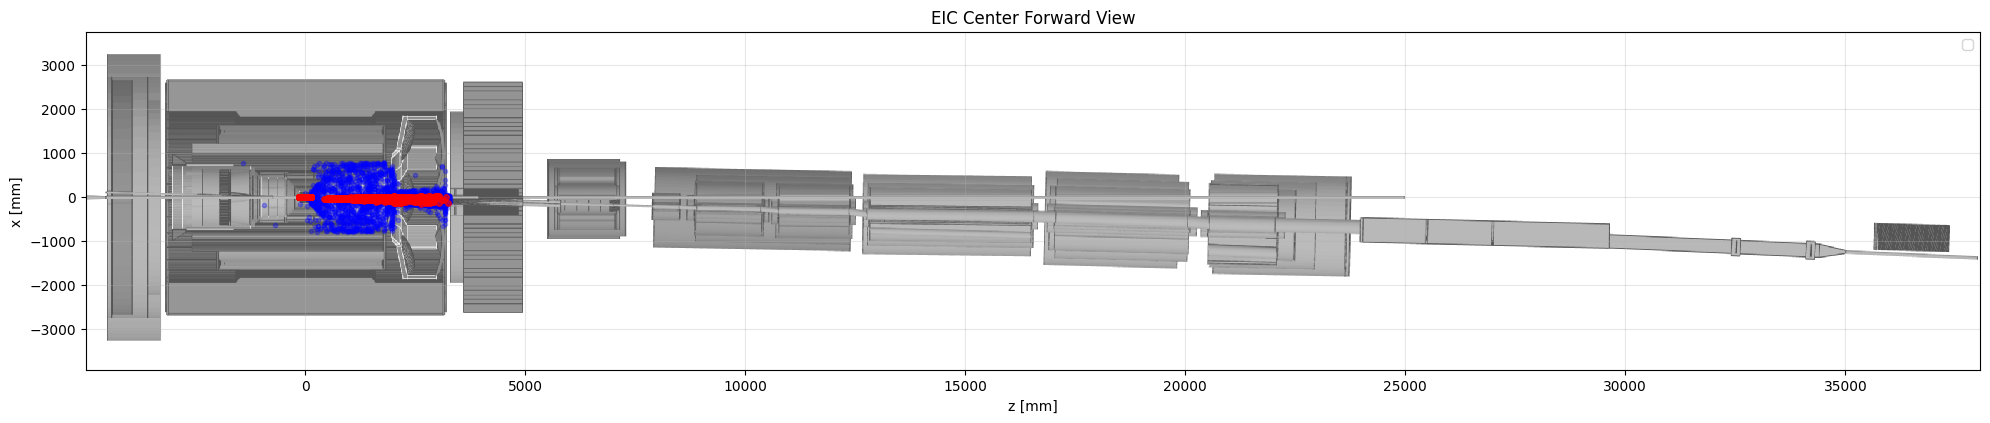

In [93]:
low_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == False]
high_energy_lambdas = df_p_pi_minis[df_p_pi_minis['is_lam_primary'] == True]

fig, ax = create_plot_with_background(bck_image="eic_center_forward_bw.png")


ax.plot(low_energy_lambdas['lam_vz'], low_energy_lambdas['lam_vx'], 
        marker="o", linestyle="none", alpha=0.3, 
        color='blue', markersize=3, )


ax.plot(high_energy_lambdas['lam_vz'], high_energy_lambdas['lam_vx'], 
        marker="o", linestyle="none", alpha=0.7,  
        color='red', markersize=4, )

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_aspect("equal", adjustable="box")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [94]:
high_energy_lambdas

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd,prot_E,pimin_E,lambda_E,invariant_mass,is_lam_primary
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,18.343530,4.580105,22.923635,1.115598,1.0
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,19.402469,1.606190,21.008659,1.115598,1.0
7,7,4,3122,1,134217728,-0.874955,-0.206428,27.917657,0.178236,-0.011964,...,NaN,NaN,NaN,NaN,NaN,23.724715,4.229682,27.954396,1.115598,1.0
17,15,4,3122,1,134217728,0.057593,0.311856,35.954789,-0.272678,0.003106,...,NaN,NaN,NaN,NaN,NaN,31.024198,4.949292,35.973490,1.115598,1.0
18,16,4,3122,1,134217728,-0.922500,0.294632,21.868619,-0.072161,-0.027710,...,NaN,NaN,NaN,NaN,NaN,17.609950,4.308510,21.918459,1.115598,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563779,499991,4,3122,1,134217728,-0.376197,-0.311097,20.538524,-0.176856,-0.012876,...,NaN,NaN,NaN,NaN,NaN,19.129024,1.445568,20.574592,1.115598,1.0
563781,499993,4,3122,1,134217728,-0.673949,1.010529,39.499559,0.119686,0.010100,...,NaN,NaN,NaN,NaN,NaN,34.122173,5.411801,39.533974,1.115598,1.0
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,21.689563,5.087566,26.777129,1.115598,1.0
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,22.276459,3.584627,25.861086,1.115598,1.0


In [95]:
x = high_energy_lambdas['lam_epx']
y = high_energy_lambdas['lam_epy']
z = high_energy_lambdas['lam_epz']
r = np.sqrt(x**2+y**2+z**2)

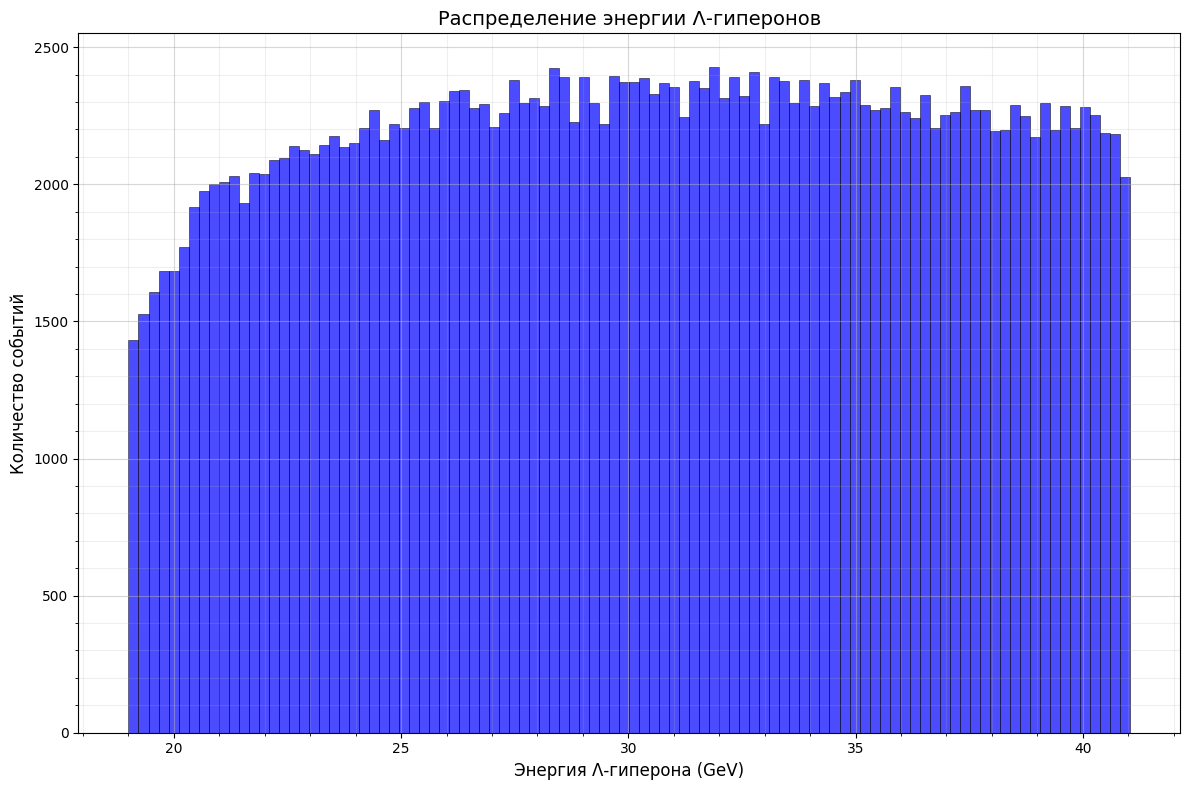

In [96]:
plt.figure(figsize=(12, 8))

plt.hist(high_energy_lambdas['lambda_E'], bins=100, alpha=0.7, color='blue', 
         edgecolor='black', linewidth=0.5)

plt.xlabel('Энергия Λ-гиперона (GeV)', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.title('Распределение энергии Λ-гиперонов', fontsize=14)
plt.grid(True, alpha=0.3)

# Добавляем более частые деления
plt.minorticks_on()
plt.grid(True, which='major', alpha=0.5)
plt.grid(True, which='minor', alpha=0.2)

plt.tight_layout()
plt.show()